# o'reillyのネゴザメ言語モデルの本

## 文字列のベクトル化（２）
推論ベースの手法 > 文脈予測アプローチ

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インストール](#インストール)
  - [インポート](#インポート)
- 推論ベースの手法 > 文脈予測アプローチ
  - [CBOWモデル](#CBOWモデル)
    - [順伝播のみの定義](#順伝播のみの定義)
    - [逆伝播を含む定義](#逆伝播を含む定義)
    - [学習して分散表現を獲得](#学習して分散表現を獲得)
      - [データの準備](#データの準備)
      - [学習の実行](#学習の実行)
      - [損失の推移をグラフ化](#損失の推移をグラフ化)
      - [単語ベクトルの類似度の上位単語を表示](#単語ベクトルの類似度の上位単語を表示)
  - [Skip-gramモデル](#Skip-gramモデル)
    - [順伝播のみの定義](#順伝播のみの定義_)
    - [逆伝播を含む定義](#逆伝播を含む定義_)
    - [学習して分散表現を獲得](#学習して分散表現を獲得_)
      - [データの準備](#データの準備_)
      - [学習の実行](#学習の実行_)
      - [損失の推移をグラフ化](#損失の推移をグラフ化_)
      - [単語ベクトルの類似度の上位単語を表示](#単語ベクトルの類似度の上位単語を表示_)

## 参考
- https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/ch02
- https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/ch03
- [言語処理（AI）> ベクトル化 - 開発基盤部会 Wiki](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86%EF%BC%88AI%EF%BC%89#k2009143) > [推論ベースの手法 > 文脈予測アプローチ](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86%EF%BC%88AI%EF%BC%89#t6fb7c98)

## 環境準備

### インストール

In [ ]:
!pip install numpy
!pip install matplotlib

### インポート

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定

## 推論ベースの手法 > 文脈予測アプローチ

### CBOWモデル
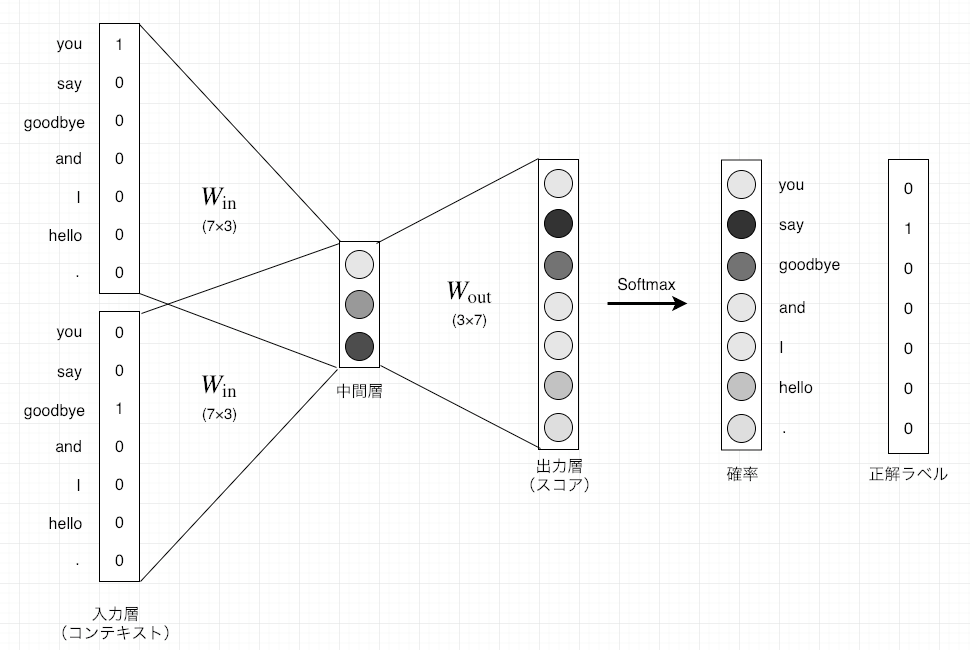

#### 順伝播のみの定義

In [ ]:
from nekozame.common.layers import MatMul

# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝搬
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

#### 逆伝播を含む定義

In [ ]:
from nekozame.common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

#### 学習して分散表現を獲得

##### データの準備

In [ ]:
from nekozame.common.trainer import Trainer
from nekozame.common.optimizer import Adam
from nekozame.common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1 # 文脈を捉えるためのウィンドウサイズ
hidden_size = 5
batch_size = 3
max_epoch = 1000

# テキスト設定
text = 'You say goodbye and I say hello.'

# 前処理
corpus, word_to_id, id_to_word = preprocess(text)
print(word_to_id)
print(id_to_word)
print(corpus)

# 単語の種類数を取得
vocab_size = len(word_to_id)
print(vocab_size)

# コンテキストとターゲット
contexts, target = create_contexts_target(corpus, window_size)
print(contexts.shape)
print(target.shape)

# One-Hotエンコーディング
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
print(contexts.shape)
print(target.shape)

##### 学習の実行

In [ ]:
# 2層のskypeのインスタンスを作成
model = SimpleCBOW(vocab_size, hidden_size)

# 最適化手法のインスタンスを作成
optimizer = Adam()

# 学習処理のインスタンスを作成
trainer = Trainer(model, optimizer)

# 学習（xがコンテキスト、yがターゲット）
trainer.fit(contexts, target, max_epoch, batch_size)

##### 損失の推移をグラフ化

In [ ]:
trainer.plot()

##### 単語ベクトルの類似度の上位単語を表示

In [ ]:
from nekozame.common.util import most_similar

# 単語ベクトルを表示
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

In [ ]:
# クエリを指定
for query in id_to_word.values():
    # 類似度の上位単語を表示
    most_similar(query, word_to_id, id_to_word, model.word_vecs, top=6)

### Skip-gramモデル
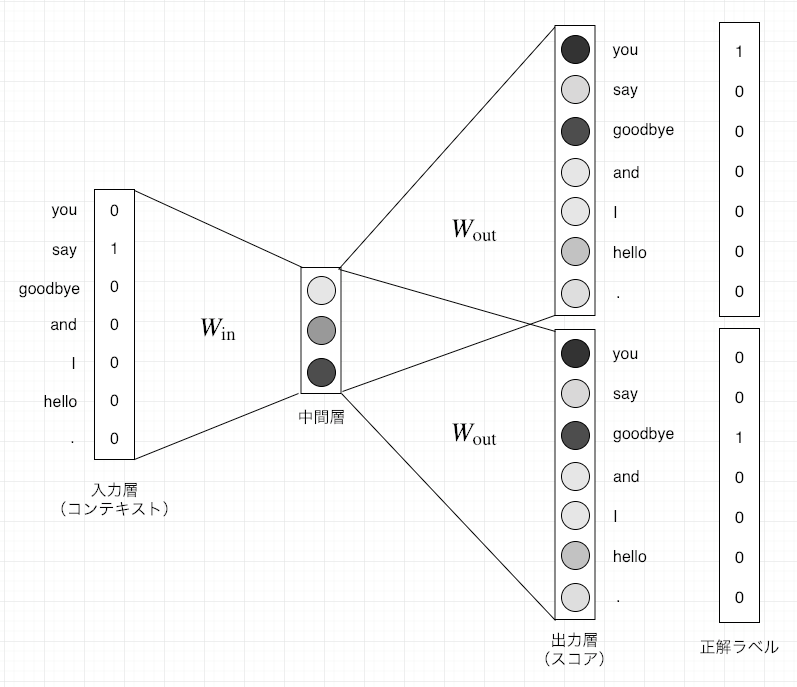

#### 逆伝播を含む定義_

In [ ]:
from nekozame.common.layers import MatMul, SoftmaxWithLoss

class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

#### 学習して分散表現を獲得_

##### データの準備_

In [ ]:
from nekozame.common.trainer import Trainer
from nekozame.common.optimizer import Adam
from nekozame.common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1 # 文脈を捉えるためのウィンドウサイズ
batch_size = 2

# テキスト設定
text = 'You say goodbye and I say hello.'

# 前処理
corpus, word_to_id, id_to_word = preprocess(text)
print(word_to_id)
print(id_to_word)
print(corpus)

# 単語の種類数を取得
vocab_size = len(word_to_id)
print(vocab_size)

# コンテキストとターゲット
contexts, target = create_contexts_target(corpus, window_size)
print(contexts.shape)
print(target.shape)

# One-Hotエンコーディング
contexts = convert_one_hot(contexts, vocab_size)
target = convert_one_hot(target, vocab_size)
print(contexts.shape)
print(target.shape)

##### 学習の実行_

In [ ]:
# 2層のskypeのインスタンスを作成
model = SimpleSkipGram(vocab_size, hidden_size)

# 最適化手法のインスタンスを作成
optimizer = Adam()

# 学習処理のインスタンスを作成
trainer = Trainer(model, optimizer)

# 学習（xがコンテキスト、yがターゲット）
trainer.fit(contexts, target, max_epoch, batch_size, eval_interval=2)

##### 損失の推移をグラフ化_

In [ ]:
trainer.plot()

##### 単語ベクトルの類似度の上位単語を表示_

In [ ]:
from nekozame.common.util import most_similar

# 単語ベクトルを表示
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

In [ ]:
# クエリを指定
for query in id_to_word.values():
    # 類似度の上位単語を表示
    most_similar(query, word_to_id, id_to_word, model.word_vecs, top=6)